In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def makePlot(cv_model, alphas, line=True):
    plt.figure(figsize = (10,8))
    _ = plt.plot(alphas, cv_model[0,:], marker='.', label = solvers[0])
    _ = plt.plot(alphas, cv_model[1,:], marker=',', label = solvers[1])
    _ = plt.plot(alphas, cv_model[2,:], marker='o', label = solvers[2])
    plt.xlabel("Alpha", fontsize=12)
    plt.ylabel("RMSE", fontsize=12)
    if line == True:
        xposition = alphas[np.argmin(cv_ridge[0,:])]
        #plt.axvline(x=xposition, color='k', linestyle='--')
        #plt.text(xposition + 0.08, 0.1375, 'Minimum Alpha', rotation=0)
    _ = plt.title("Alpha vs. RMSE for different Alphas, Solvers", fontsize=15)
    _ = plt.legend()

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

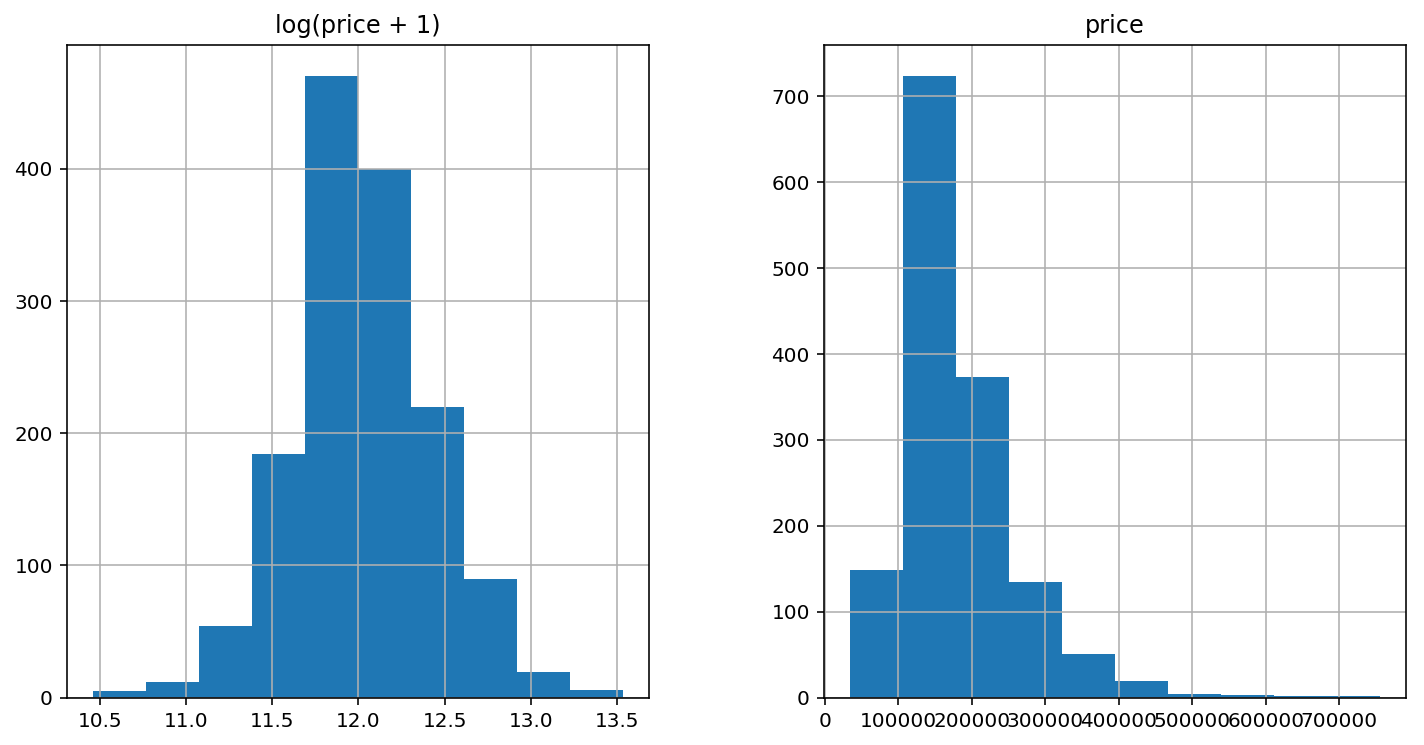

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
_ = prices.hist()

In [6]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
all_data = pd.get_dummies(all_data)

In [8]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [9]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [15]:
model_ridge = Ridge()

In [12]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

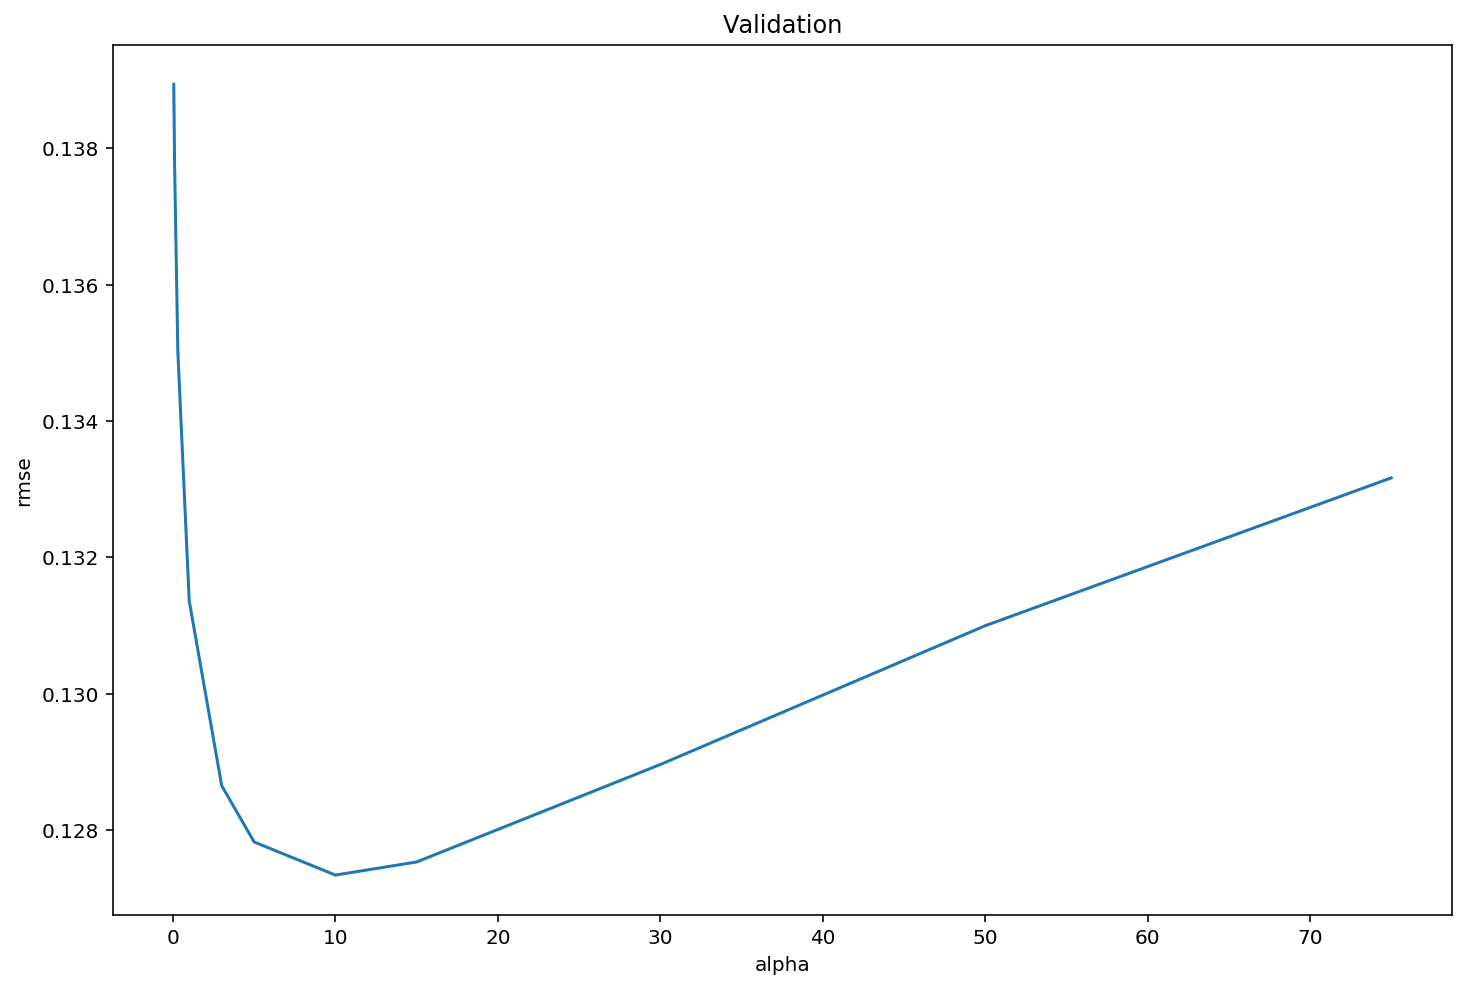

In [38]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
_ = cv_ridge.plot(title = "Validation", figsize = (12,8))
plt.xlabel("alpha")
plt.ylabel("rmse")

In [15]:
cv_ridge.min()

0.12733734668670757

In [16]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [17]:
rmse_cv(model_lasso).mean()

0.1231442109097745

In [18]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [19]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 111 variables and eliminated the other 177 variables


In [20]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

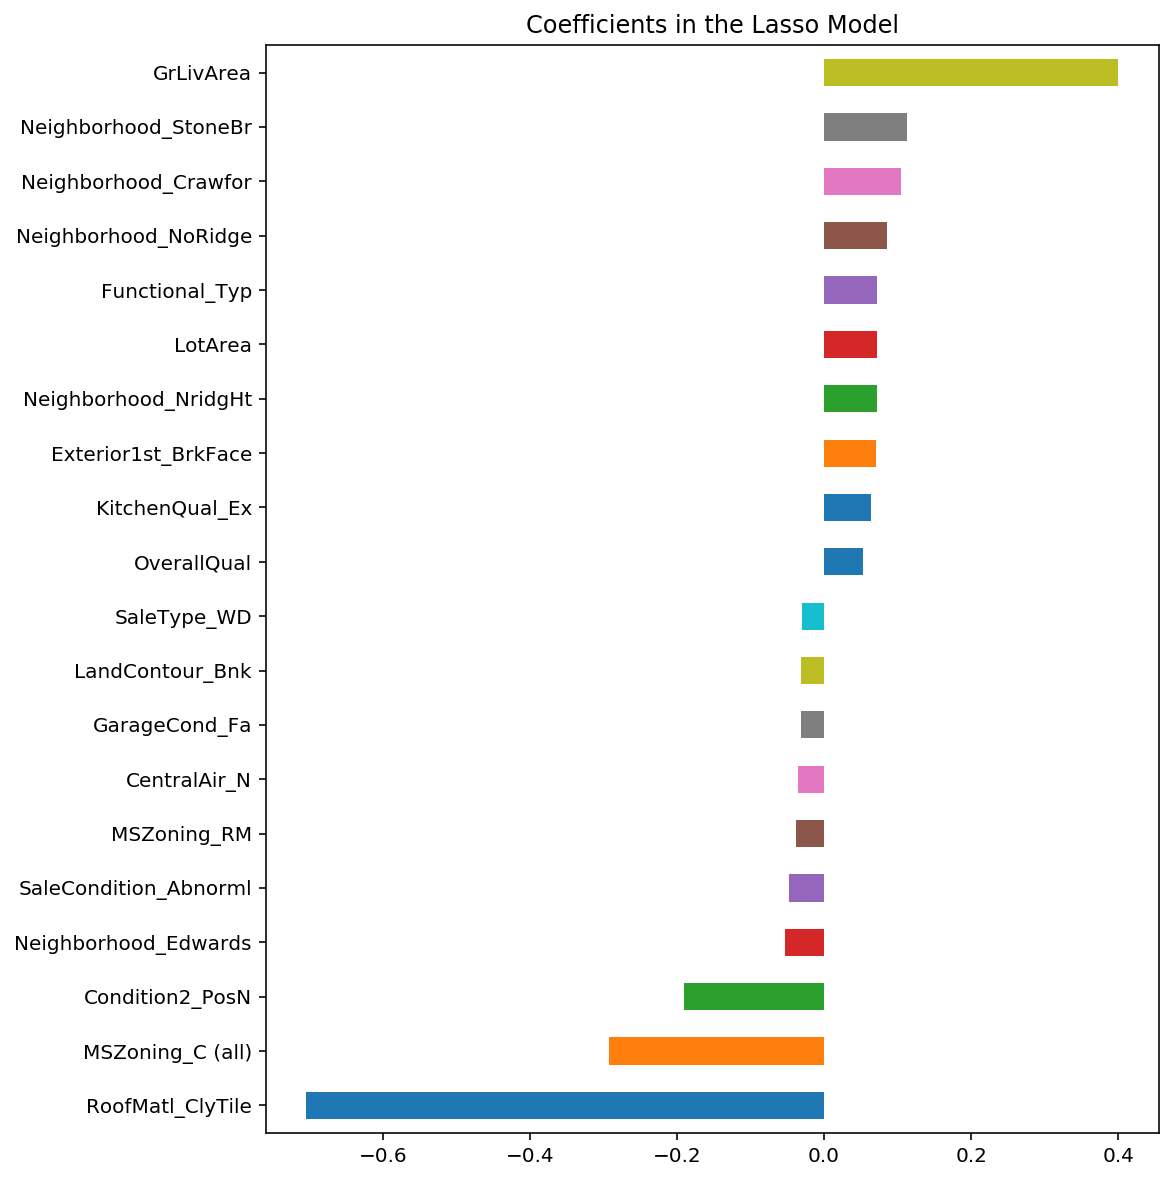

In [23]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
_ = plt.title("Coefficients in the Lasso Model")

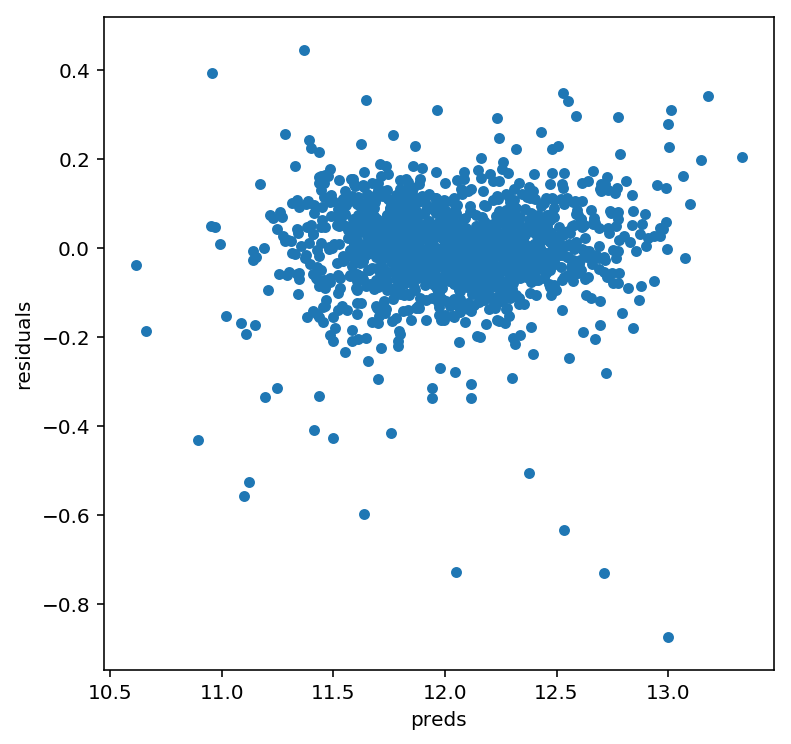

In [22]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
_ = preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [25]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

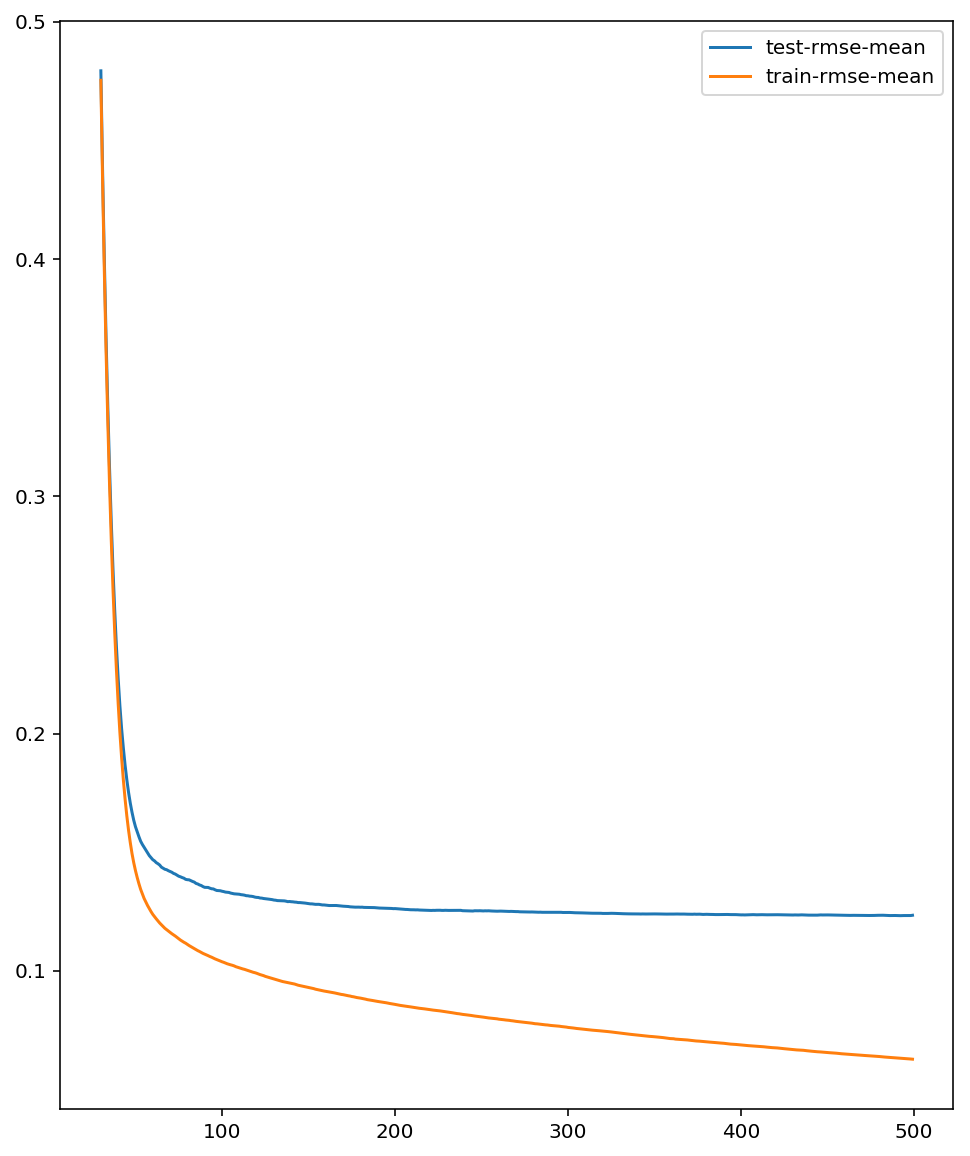

In [31]:
_ = model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [32]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

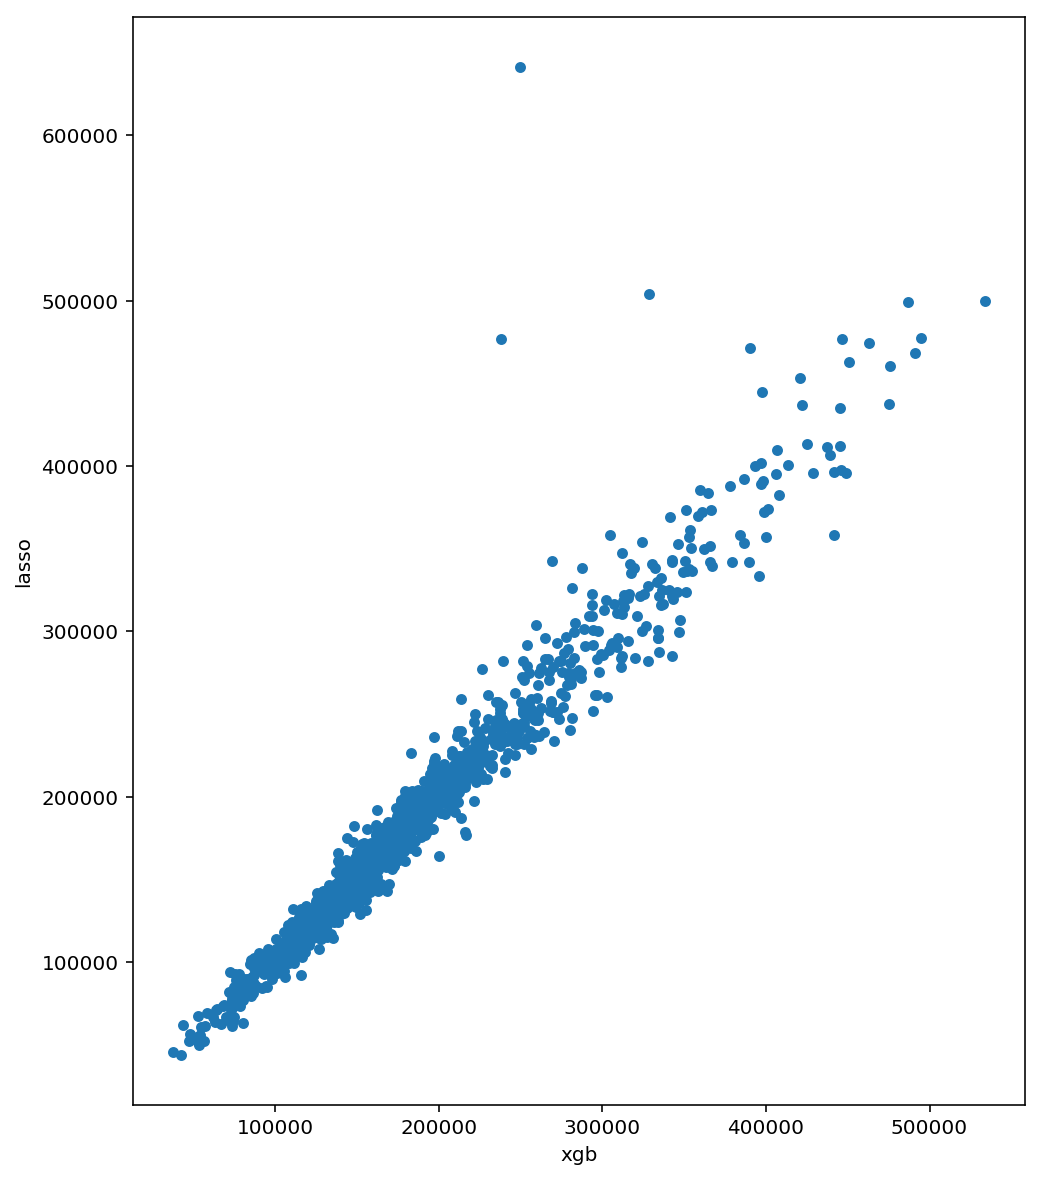

In [34]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
_ = predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [35]:
preds = 0.7*lasso_preds + 0.3*xgb_preds
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

In [39]:
all_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,3.820503,4.196175,9.094915,6.089072,5.564577,1971.312778,1984.264474,2.095752,4.226403,0.681207,...,0.002741,0.081877,0.002398,0.865022,0.065091,0.004111,0.008222,0.015759,0.822885,0.083933
std,0.692436,0.320316,0.509882,1.409947,1.113131,30.291442,20.894344,2.614355,2.980814,1.878488,...,0.052289,0.274225,0.048920,0.341758,0.246728,0.063996,0.090317,0.124562,0.381832,0.277335
min,3.044522,3.091042,7.170888,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.044522,4.110874,8.919854,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.931826,4.196175,9.154193,6.000000,5.000000,1973.000000,1993.000000,0.000000,5.910797,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.262680,4.369448,9.356257,7.000000,6.000000,2001.000000,2004.000000,5.102906,6.598509,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.252273,5.749393,12.279537,10.000000,9.000000,2010.000000,2010.000000,7.378384,8.638525,7.331060,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


### Cleaning up the data to make a better model

In [59]:
########################################################
# Download, pick columns, clean data
########################################################

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
#log transform the target:
#train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
#numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#compute skewness
#skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
#skewed_feats = skewed_feats[skewed_feats > 0.75]
#skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
smaller_data = all_data.loc[:, ['OverallQual', 'YearRemodAdd', 
                                'YearBuilt', '1stFlrSF', 'GarageArea', 
                                'GrLivArea']]
# Clean zeros and NaN
smaller_data.isnull().sum()
smaller_data = smaller_data.fillna(0)
smaller_data.isnull().sum()

#creating matrices for sklearn:
X_train = smaller_data[:train.shape[0]]
X_test = smaller_data[train.shape[0]:]
y = train.SalePrice

#### Check correlation of prepared data

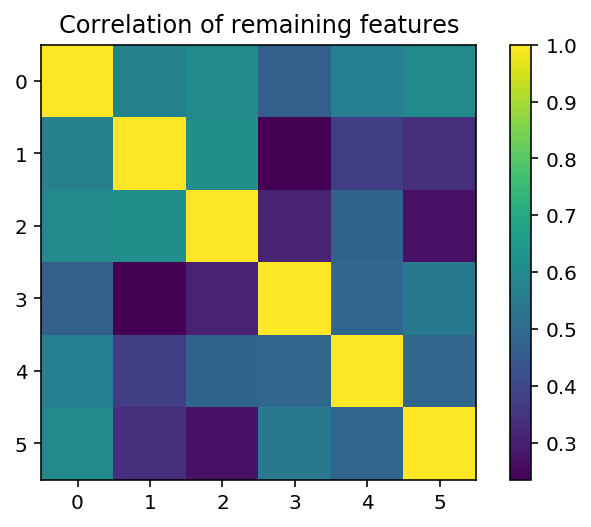

In [60]:
fig, ax = plt.subplots()
plt.imshow(smaller_data.corr())
_ = plt.colorbar()
_ = plt.title('Correlation of remaining features')
#_ = ax.set_xticks(smaller_data.columns.values)
#_ = ax.set_yticklabels(smaller_data.columns.values)

### Testing different solvers, alphas, and models

In [68]:
###########################################################
# Test different solvers and alphas for Ridge Regression
##########################################################
solvers = ['svd', 'cholesky', 'lsqr']
num_alphas = 11
alphas = [0.001*1.5**x for x in range(num_alphas)]

cv_ridge = [[rmse_cv(Ridge(alpha = alpha, normalize=True, solver= solver)).mean() 
            for alpha in alphas] for solver in solvers]
cv_ridge = np.array(cv_ridge)

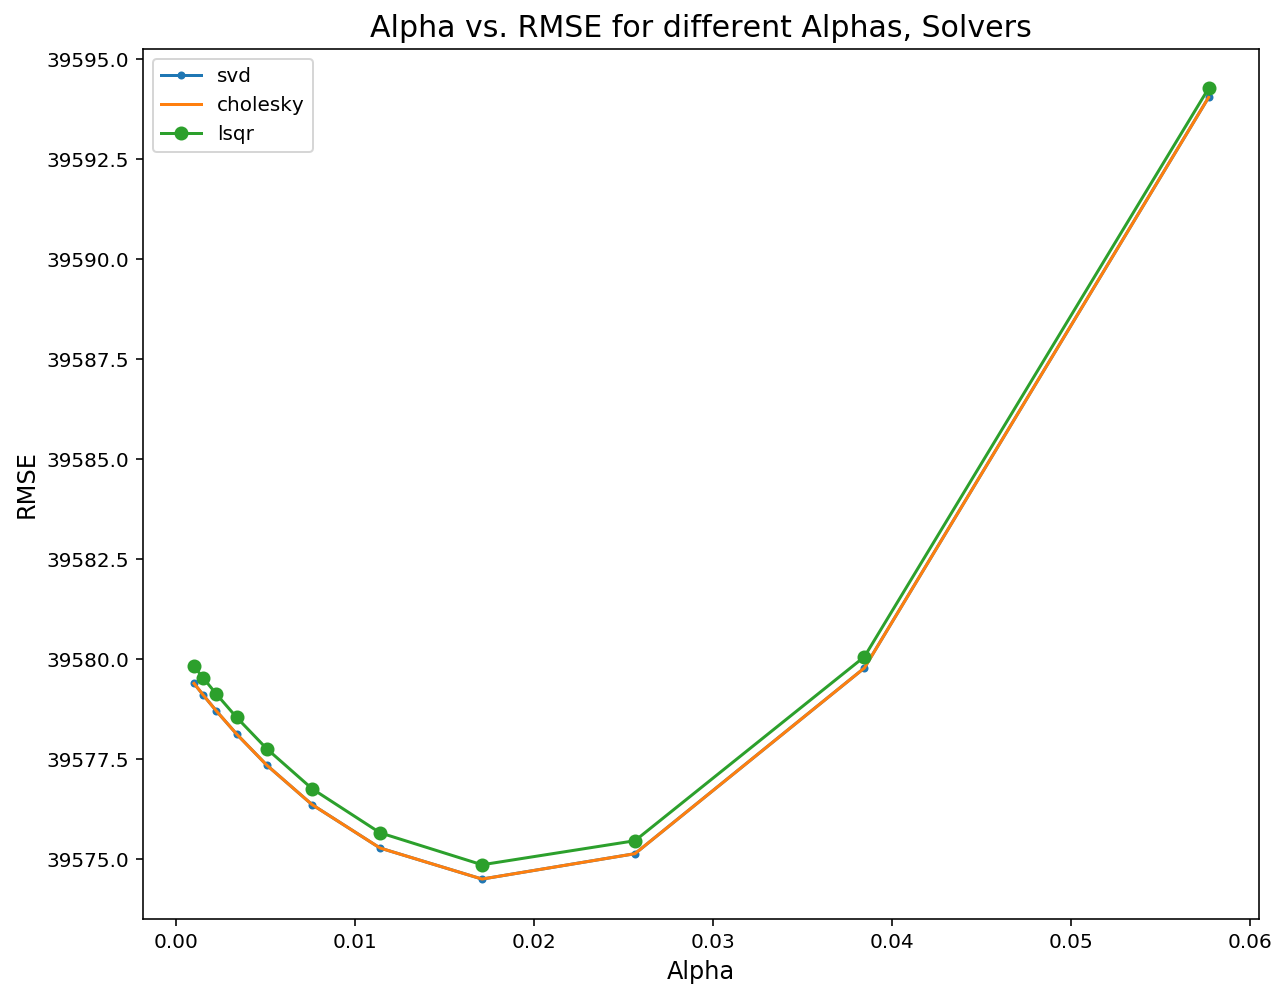

In [74]:
makePlot(cv_ridge, alphas)

In [75]:
###########################################################
# Zoom in on alphas
##########################################################
solvers = ['svd', 'cholesky', 'lsqr']
num_alphas_2 = 18
alphas_2 = np.arange(0.01, 0.032, 0.001)

cv_ridge_2 = [[rmse_cv(Ridge(alpha=alpha, normalize=True, solver= solver)).mean() 
            for alpha in alphas_2] for solver in solvers]
cv_ridge_2 = np.array(cv_ridge_2)

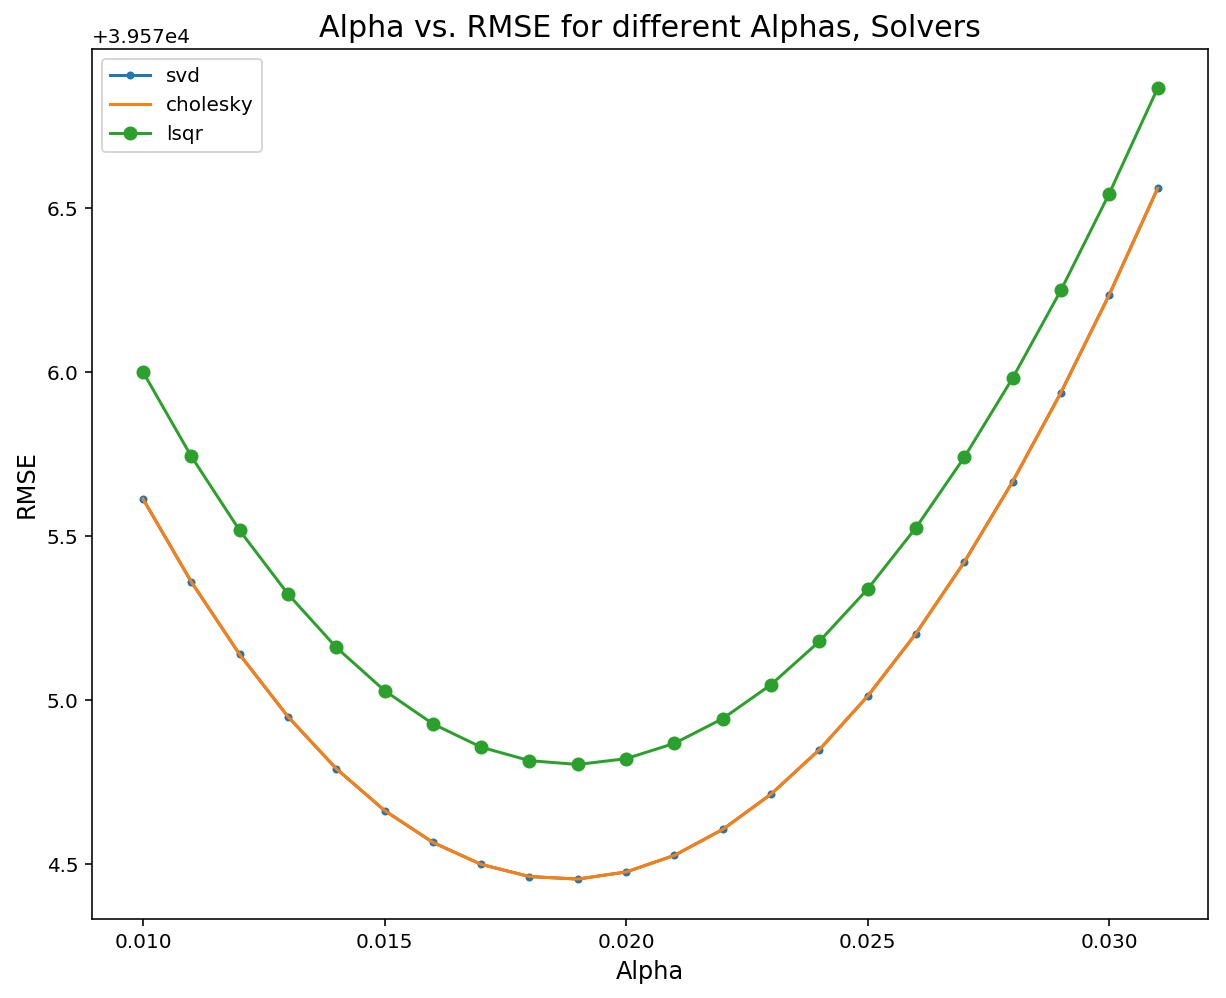

In [76]:
###########################################################
# Replot
##########################################################
makePlot(cv_ridge_2, alphas_2)

### Verify the min alpha for $L^2$ regularization

In [85]:
l2_reg = alphas_2[np.argmin(cv_ridge_2[1,:])]
print(l2_reg)

0.018999999999999993


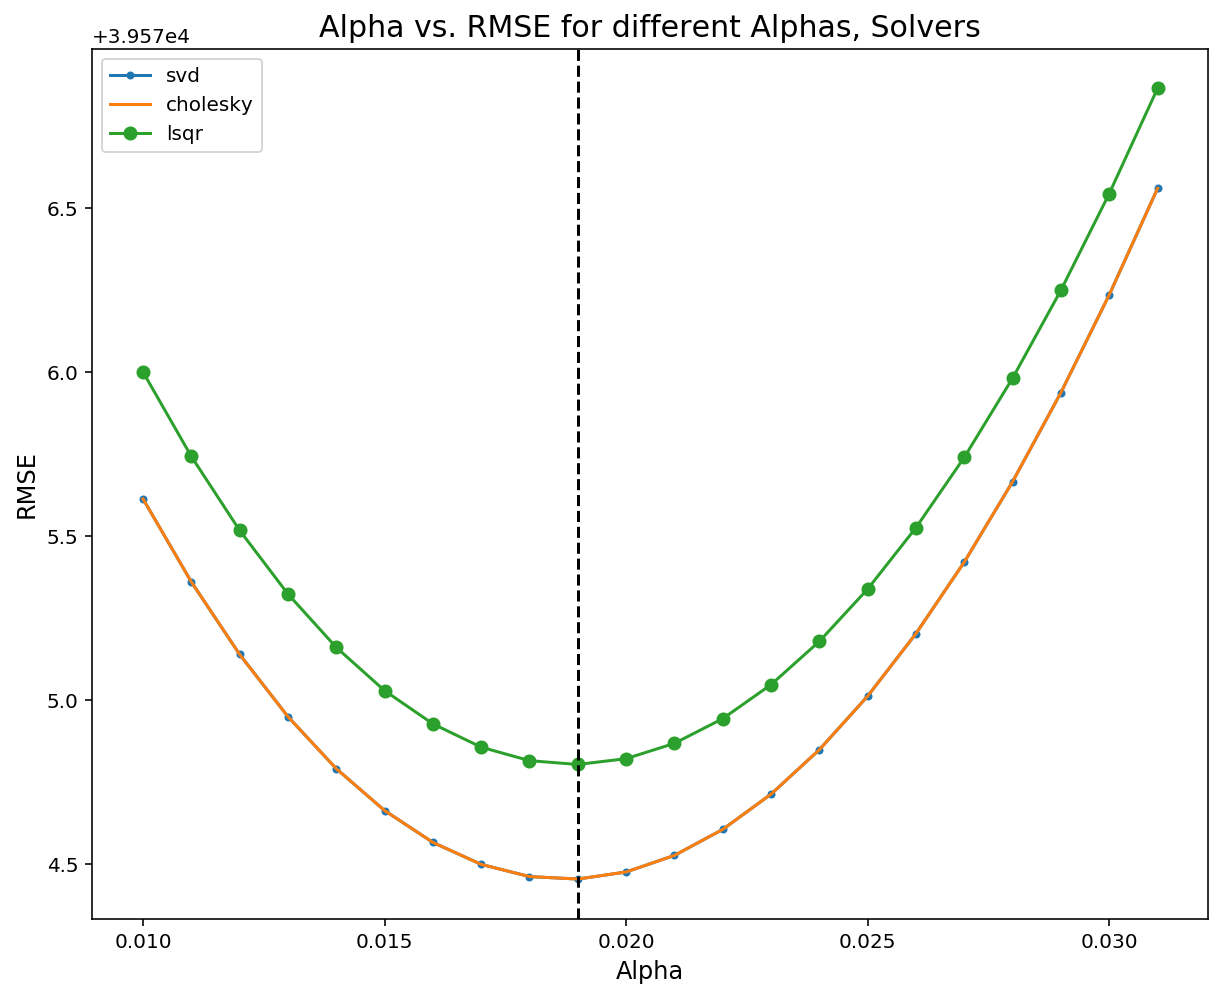

In [86]:
plt.figure(figsize = (10,8))
_ = plt.plot(alphas_2, cv_ridge_2[0,:], marker='.', label = solvers[0])
_ = plt.plot(alphas_2, cv_ridge_2[1,:], marker=',', label = solvers[1])
_ = plt.plot(alphas_2, cv_ridge_2[2,:], marker='o', label = solvers[2])
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
xposition = 0.0189999999
plt.axvline(x=xposition, color='k', linestyle='--')
        #plt.text(xposition + 0.08, 0.1375, 'Minimum Alpha', rotation=0)
_ = plt.title("Alpha vs. RMSE for different Alphas, Solvers", fontsize=15)
_ = plt.legend()

In [95]:
#########################################
# Redoing with XGDboost
########################################
boosters = ['gbtree', 'gblinear', 'dart']
etas = np.arange(0.001, 0.8, 0.01)

cv_xgboost = [[rmse_cv(XGBRegressor(learning_rate=eta, booster=booster)).mean() 
            for eta in etas] for booster in boosters]

cv_xgboost = np.array(cv_xgboost)

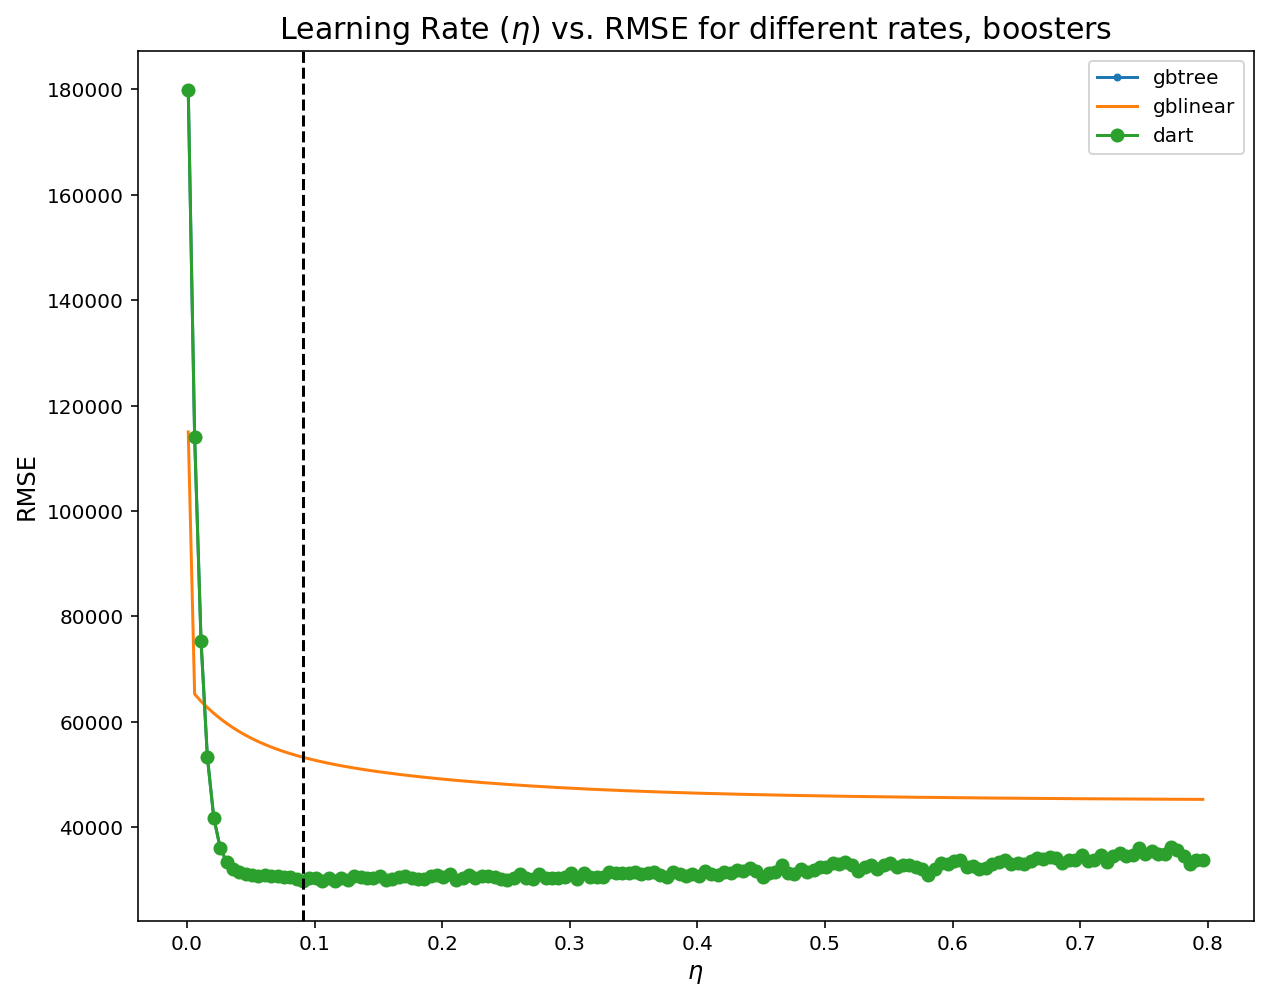

In [97]:
plt.figure(figsize = (10,8))
_ = plt.plot(etas, cv_xgboost[0,:], marker='.', label = boosters[0])
_ = plt.plot(etas, cv_xgboost[1,:], marker=',', label = boosters[1])
_ = plt.plot(etas, cv_xgboost[2,:], marker='o', label = boosters[2])
plt.xlabel("$\eta$", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
xposition = etas[np.argmin(cv_xgboost[2,:])]
plt.axvline(x=xposition, color='k', linestyle='--')
        #plt.text(xposition + 0.08, 0.1375, 'Minimum Alpha', rotation=0)
_ = plt.title("Learning Rate ($\eta$) vs. RMSE for different rates, boosters", fontsize=15)
_ = plt.legend()

### Zooming in on the region where the minimum is

In [98]:
boosters = ['gbtree', 'dart']
etas = np.arange(0.01, 0.2, 0.01)

cv_xgboost = [[rmse_cv(XGBRegressor(learning_rate=eta, booster=booster)).mean() 
            for eta in etas] for booster in boosters]

cv_xgboost = np.array(cv_xgboost)

0.12


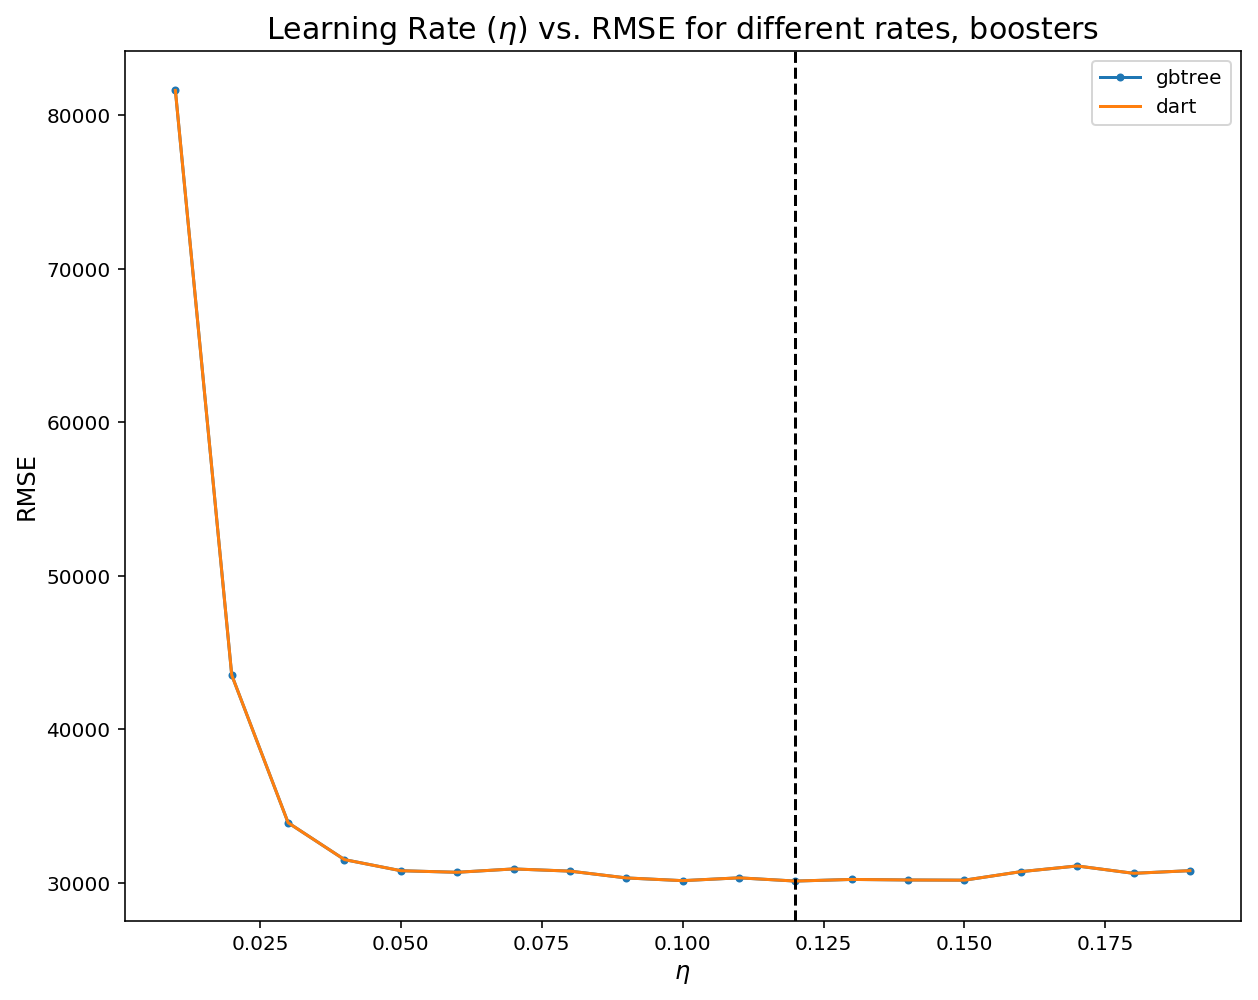

In [100]:
plt.figure(figsize = (10,8))
_ = plt.plot(etas, cv_xgboost[0,:], marker='.', label = boosters[0])
_ = plt.plot(etas, cv_xgboost[1,:], marker=',', label = boosters[1])
plt.xlabel("$\eta$", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
xposition = etas[np.argmin(cv_xgboost[1,:])]
plt.axvline(x=xposition, color='k', linestyle='--')
        #plt.text(xposition + 0.08, 0.1375, 'Minimum Alpha', rotation=0)
_ = plt.title("Learning Rate ($\eta$) vs. RMSE for different rates, boosters", fontsize=15)
_ = plt.legend()
print(xposition)

In [104]:
model = XGBRegressor(learning_rate=0.12, booster='dart')
_ = model.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.12, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [127]:
_ = model.predict(X_test)
new_index = np.arange(1461,2920,1)

index = pd.DataFrame(new_index, columns=['Id'])
y_hat = pd.DataFrame(_, columns=['SalePrice'])
frames = [index, y_hat]
pred = pd.concat(frames, axis=1)
pred.head()

,Id,SalePrice
0,1461,129776.914062
1,1462,141023.125000
2,1463,163525.484375
3,1464,178384.703125
4,1465,208871.890625


In [128]:
filename = 'prediction.csv'
pred.to_csv(filename, encoding='utf-8', index=False)